<a href="https://colab.research.google.com/github/jhubar/Application-of-convolutional-neural-network-in-chess-evaluation/blob/master/xgBoost_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import jax.numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/pepite/data/open dataset/higgs.csv')

In [3]:
from xgboost import XGBClassifier
df_small = df.sample(n=10000, random_state=42)

# Split data into features and labels
X = df_small.iloc[:, 1:]
y = df_small.iloc[:, 0]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove missing values
X_train = X_train.replace(-999, np.nan).dropna(axis=0)
y_train = y_train[X_train.index]
X_test = X_test.replace(-999, np.nan).dropna(axis=0)
y_test = y_test[X_test.index]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
xgb = XGBClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, verbose=3, n_jobs=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


GridSearchCV(cv=5, estimator=XGBClassifier(random_state=42), n_jobs=3,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 6, 9], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100],
                         'subsample': [0.5, 0.7, 1.0]},
             verbose=3)

[learning_curve] Training set sizes: [ 640 1280 1920 2560 3200 3840 4480 5120 5760 6400]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  17 out of  50 | elapsed:    8.4s remaining:   16.3s
[Parallel(n_jobs=3)]: Done  34 out of  50 | elapsed:   18.9s remaining:    8.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   30.2s finished


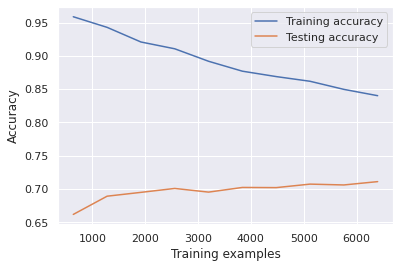

In [ ]:
# Evaluate the best model on the testing set and plot the learning curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

best_model = grid_search.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10), verbose=3, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training accuracy')
plt.plot(train_sizes, test_scores_mean, label='Testing accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Print the best hyperparameters found by the grid search
print('Best hyperparameters:')
print(grid_search.best_params_)

Best hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.7}


# GPU time computation vs cpu

In [3]:
import torch 
print(torch.cuda.get_device_name(0))

Tesla T4


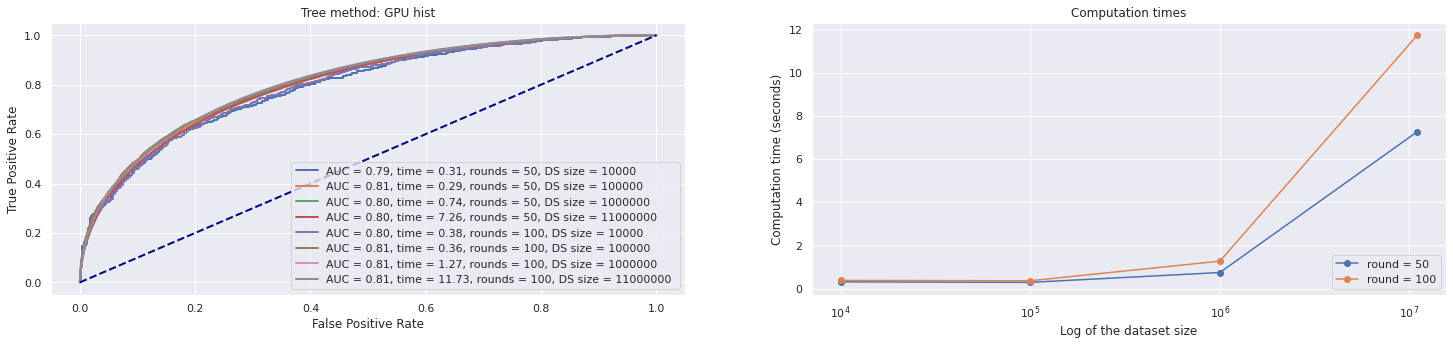

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

params = {
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist',
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.7
}
# Plot ROC curve
fig, axes = plt.subplots(1, 2,figsize=(25, 5))
sample_sizes = [10000,100000,1000000,11000000]

num_rounds = [50,100]
for num_round in num_rounds:
  computation_times = []
  for sample_size in sample_sizes:
    df_sampled = df.sample(n=sample_size, random_state=42)
    X = df_sampled.iloc[:, 1:]
    y = df_sampled.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    
    start = time.time()
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)
    stop = time.time()



    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    computation_times.append((stop-start))
    axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}, time = {(stop-start):.2f}, rounds = {num_round}, DS size = {sample_size} ')
  axes[1].plot(sample_sizes, computation_times, 'o-', label = f'round = {num_round}')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tree method: GPU hist')
axes[0].legend(loc="lower right")
axes[1].set_xscale('log')



# Plot the computation times as a function of dataset size

axes[1].set_xlabel('Log of the dataset size')
axes[1].set_ylabel('Computation time (seconds)')
axes[1].set_title('Computation times')
axes[1].legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/pepite/data/open dataset/roc_gpu_all.png")
plt.show()


# Tree methode: hist

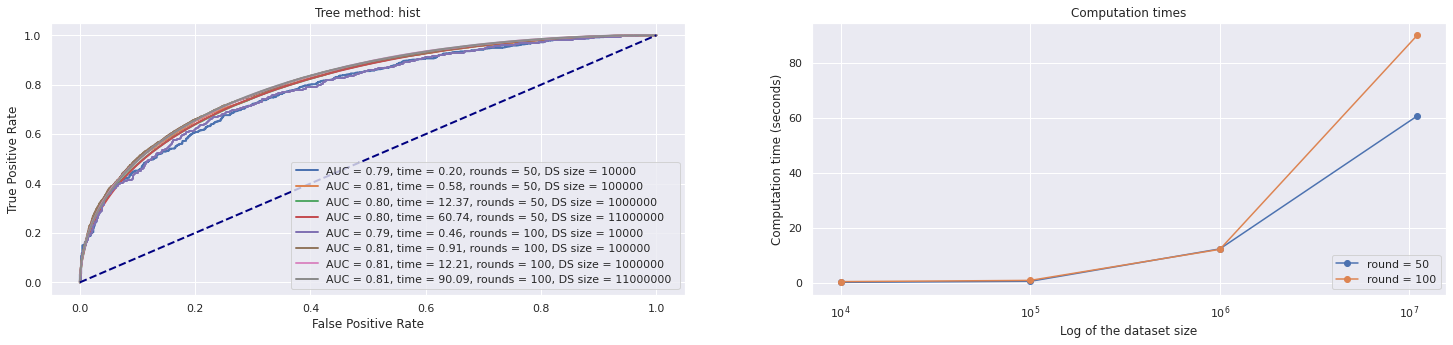

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

params = {
    'objective': 'binary:logistic', 
    'tree_method': 'hist',
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.7
}
# Plot ROC curve
fig, axes = plt.subplots(1, 2,figsize=(25, 5))
sample_sizes = [10000,100000,1000000,11000000]

num_rounds = [50,100]
for num_round in num_rounds:
  computation_times = []
  for sample_size in sample_sizes:
    df_sampled = df.sample(n=sample_size, random_state=42)
    X = df_sampled.iloc[:, 1:]
    y = df_sampled.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    
    start = time.time()
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)
    stop = time.time()



    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    computation_times.append((stop-start))
    axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}, time = {(stop-start):.2f}, rounds = {num_round}, DS size = {sample_size} ')
  axes[1].plot(sample_sizes, computation_times, 'o-', label = f'round = {num_round}')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tree method: hist')
axes[0].legend(loc="lower right")
axes[1].set_xscale('log')



# Plot the computation times as a function of dataset size

axes[1].set_xlabel('Log of the dataset size')
axes[1].set_ylabel('Computation time (seconds)')
axes[1].set_title('Computation times')
axes[1].legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/pepite/data/open dataset/roc_hist_all.png")
plt.show()


# Tree method: approx



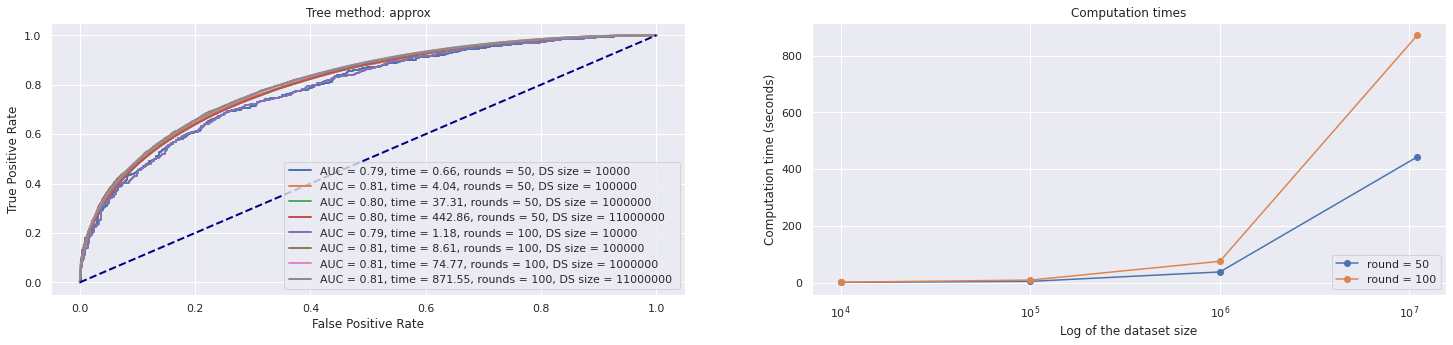

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

params = {
    'objective': 'binary:logistic', 
    'tree_method': 'approx',
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.7
}
# Plot ROC curve
fig, axes = plt.subplots(1, 2,figsize=(25, 5))
sample_sizes = [10000,100000,1000000,11000000]

num_rounds = [50,100]
for num_round in num_rounds:
  computation_times = []
  for sample_size in sample_sizes:
    df_sampled = df.sample(n=sample_size, random_state=42)
    X = df_sampled.iloc[:, 1:]
    y = df_sampled.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    
    start = time.time()
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)
    stop = time.time()



    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    computation_times.append((stop-start))
    axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}, time = {(stop-start):.2f}, rounds = {num_round}, DS size = {sample_size} ')
  axes[1].plot(sample_sizes, computation_times, 'o-', label = f'round = {num_round}')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tree method: approx')
axes[0].legend(loc="lower right")
axes[1].set_xscale('log')



# Plot the computation times as a function of dataset size

axes[1].set_xlabel('Log of the dataset size')
axes[1].set_ylabel('Computation time (seconds)')
axes[1].set_title('Computation times')
axes[1].legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/pepite/data/open dataset/roc_approx_all.png")
plt.show()


# Tree method: exact

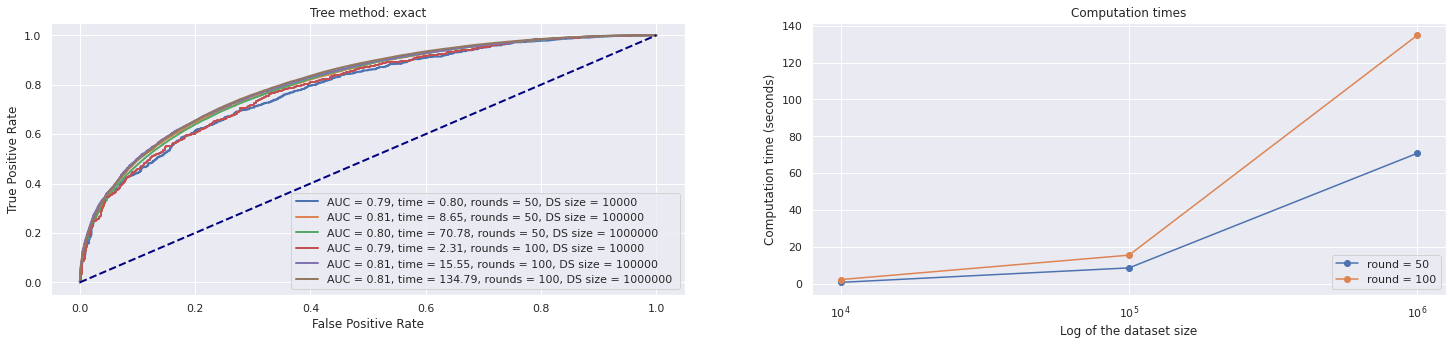

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

params = {
    'objective': 'binary:logistic', 
    'tree_method': 'exact',
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.7
}
# Plot ROC curve
fig, axes = plt.subplots(1, 2,figsize=(25, 5))
sample_sizes = [10000,100000,1000000]

num_rounds = [50,100]
for num_round in num_rounds:
  computation_times = []
  for sample_size in sample_sizes:
    df_sampled = df.sample(n=sample_size, random_state=42)
    X = df_sampled.iloc[:, 1:]
    y = df_sampled.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    
    start = time.time()
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)
    stop = time.time()



    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    computation_times.append((stop-start))
    axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}, time = {(stop-start):.2f}, rounds = {num_round}, DS size = {sample_size} ')
  axes[1].plot(sample_sizes, computation_times, 'o-', label = f'round = {num_round}')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tree method: exact')
axes[0].legend(loc="lower right")
axes[1].set_xscale('log')



# Plot the computation times as a function of dataset size

axes[1].set_xlabel('Log of the dataset size')
axes[1].set_ylabel('Computation time (seconds)')
axes[1].set_title('Computation times')
axes[1].legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/pepite/data/open dataset/roc_exact_all.png")
plt.show()


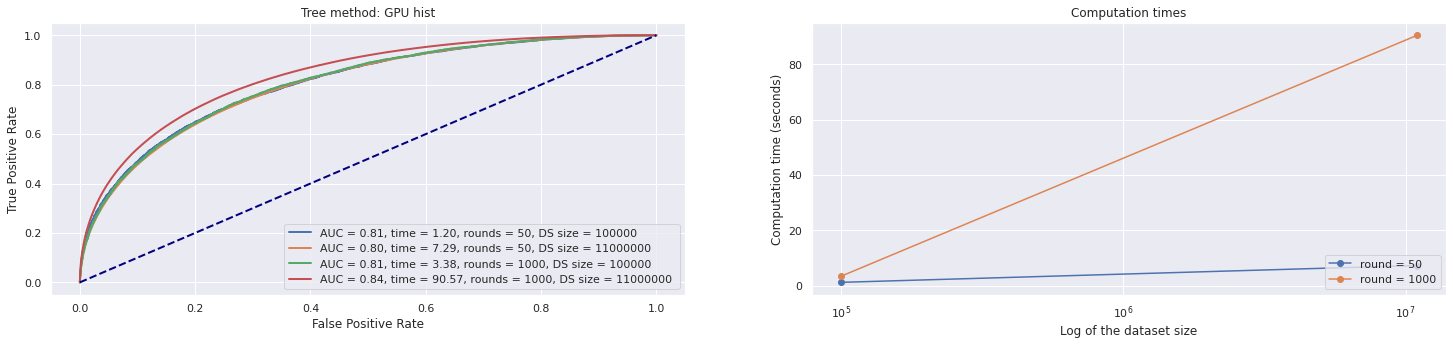

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

params = {
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist',
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.7
}
# Plot ROC curve
fig, axes = plt.subplots(1, 2,figsize=(25, 5))
sample_sizes = [100000,11000000]

num_rounds = [50,1000]
for num_round in num_rounds:
  computation_times = []
  for sample_size in sample_sizes:
    df_sampled = df.sample(n=sample_size, random_state=42)
    X = df_sampled.iloc[:, 1:]
    y = df_sampled.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    
    start = time.time()
    model = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)
    stop = time.time()



    # Calculate false positive rate, true positive rate, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    computation_times.append((stop-start))
    axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}, time = {(stop-start):.2f}, rounds = {num_round}, DS size = {sample_size} ')
  axes[1].plot(sample_sizes, computation_times, 'o-', label = f'round = {num_round}')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tree method: GPU hist')
axes[0].legend(loc="lower right")
axes[1].set_xscale('log')



# Plot the computation times as a function of dataset size

axes[1].set_xlabel('Log of the dataset size')
axes[1].set_ylabel('Computation time (seconds)')
axes[1].set_title('Computation times')
axes[1].legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/pepite/data/open dataset/roc_gpu_all.png")
plt.show()
